## Simulate data

In [1]:
import pandas as pd
import numpy as np
import random

np.random.seed(37)
random.seed(37)

def sample(mean, std_dev, N=100):
    s = np.random.normal(mean, std_dev, N)
    s = np.clip(s, 0, 1)
    s = pd.Series(s)
    return s

df = pd.DataFrame({
    's1': sample(0.4, 0.15),
    's2': sample(0.5, 0.1),
    's3': sample(0.6, 0.2)
})

df.head()

,s1,s2,s3
0,0.391830,0.585214,0.241398
1,0.501146,0.609859,0.534833
2,0.451997,0.471076,0.557154
3,0.204948,0.721115,0.466191
4,0.627777,0.443239,0.701549


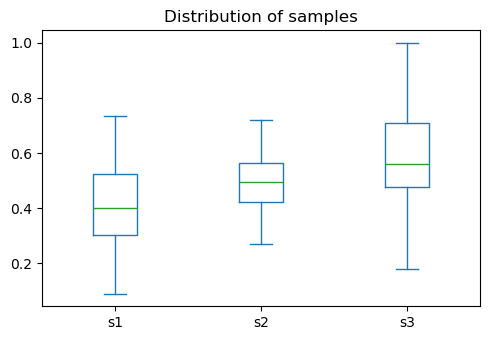

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3.5))

df.plot(kind='box', ax=ax)
ax.set_title('Distribution of samples')

fig.tight_layout()

## Merge

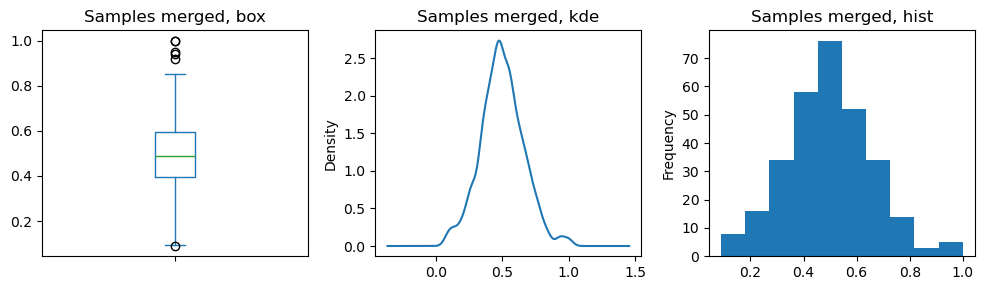

In [3]:
p = pd.Series(np.ravel(df))

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

p.plot(kind='box', ax=ax[0])
p.plot(kind='kde', ax=ax[1], bw_method=0.2)
p.plot(kind='hist', ax=ax[2])

ax[0].set_title('Samples merged, box')
ax[1].set_title('Samples merged, kde')
ax[2].set_title('Samples merged, hist')

fig.tight_layout()

## Best entropy

In [4]:
from sklearn.mixture import GaussianMixture

def l2m(means):
    return {i: m for i, m in enumerate(np.ravel(means))}

def m2o(means):
    return {m: i for i, m in enumerate(sorted(np.ravel(means)))}

def l2o(means):
    _l2m = l2m(means)
    _m2o = m2o(means)
    return {l: _m2o[m] for l, m in _l2m.items()}

def get_entropy(s):
    p = s / s.sum()
    p = np.sum([p_i * np.log2(p_i) for p_i in p])
    p = -p
    return p

def compute_entropy(X, n_components):
    m = GaussianMixture(n_components=n_components, random_state=37)
    m.fit(X)

    lab2ord = l2o(m.means_)
    s = pd.Series(m.predict(X)) \
        .map(lab2ord) \
        .value_counts() \
        .sort_index()
    h = get_entropy(s)
    return h
    
X = pd.DataFrame({'p': p})
H = pd.DataFrame([{'n': n, 'h': compute_entropy(X, n)} for n in range(10, 291)]) \
    .set_index(['n'])
H.shape

(281, 1)

<Axes: xlabel='n'>

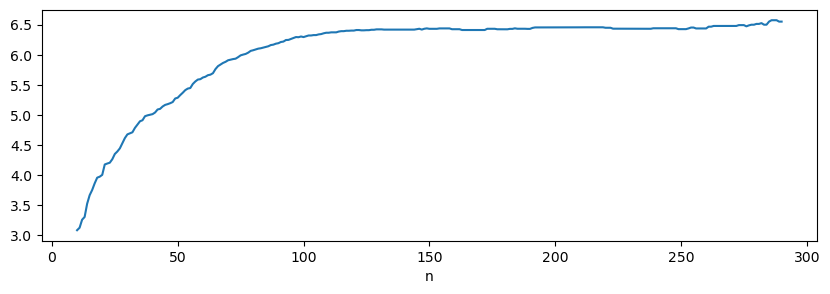

In [5]:
H['h'].plot(kind='line', figsize=(10, 3))

In [6]:
def get_labels(X, n_components):
    m = GaussianMixture(n_components=n_components, random_state=37)
    m.fit(X)
    
    lab2ord = l2o(m.means_)
    s = pd.Series(m.predict(X)) \
        .map(lab2ord) \
        .value_counts() \
        .sort_index()
    h = get_entropy(s)

    return s, h

<Axes: title={'center': 'n=20, H(y)=4.00595'}>

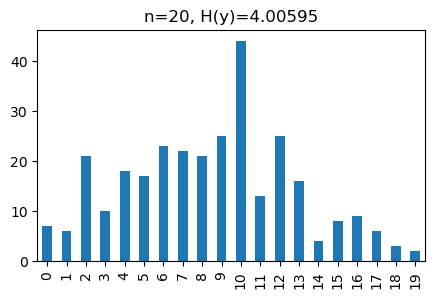

In [7]:
n = 20
s, h = get_labels(X, n)
s.plot(kind='bar', figsize=(5, 3), title=f'n={n}, H(y)={h:.5f}')

<Axes: title={'center': 'n=100, H(y)=6.29341'}>

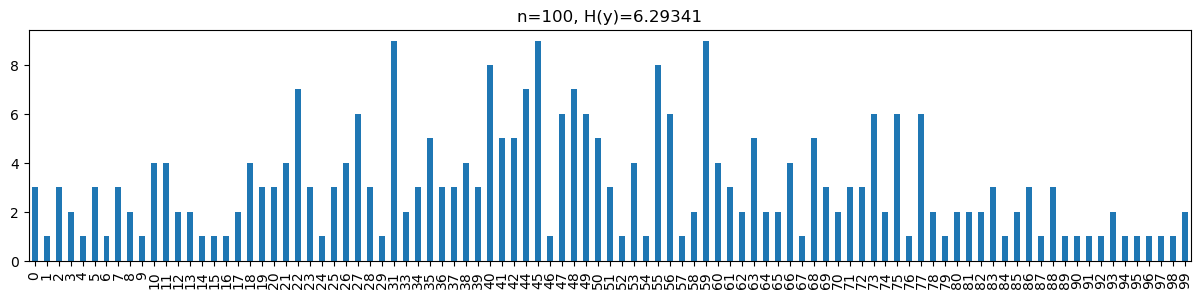

In [8]:
n = 100
s, h = get_labels(X, n)
s.plot(kind='bar', figsize=(15, 3), title=f'n={n}, H(y)={h:.5f}')

<Axes: title={'center': 'n=250, H(y)=6.42513'}>

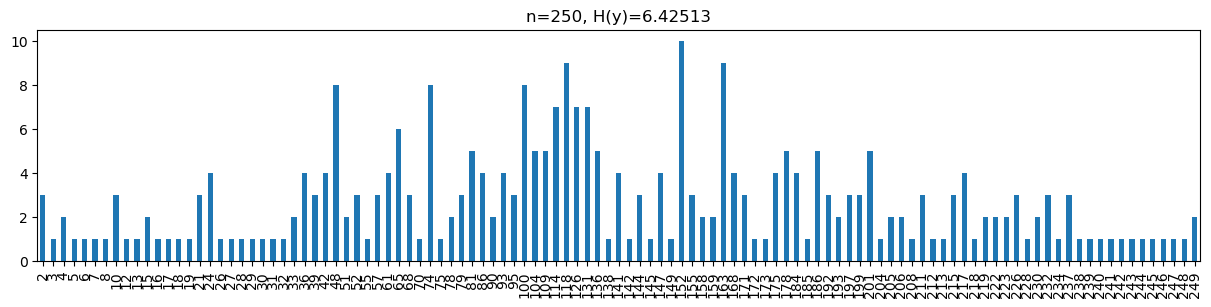

In [9]:
n = 250
s, h = get_labels(X, n)
s.plot(kind='bar', figsize=(15, 3), title=f'n={n}, H(y)={h:.5f}')

In [10]:
def rescale_values(values, new_min=0, new_max=1):
    old_min = np.min(values)
    old_max = np.max(values)
    return [(((value - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min for value in values]
    
def get_cdf(n):
    s, h = get_labels(X, n)
    c = (s.cumsum() / s.sum())
    i = rescale_values(c.index)
    v = c.values
    return pd.Series(v, i)

<Axes: >

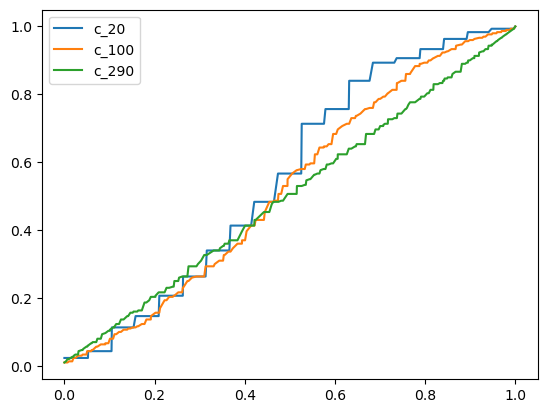

In [11]:
pd.DataFrame({
    'c_20': get_cdf(20),
    'c_100': get_cdf(100),
    'c_290': get_cdf(290)
}).ffill().plot(kind='line')

## Add noise

In [12]:
def add_noise(s, noise=1e-6):
    while True:
        d = s + np.random.uniform(-noise, noise, s.shape)
        if d.value_counts().shape[0] == s.shape[0]:
            break
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = bins[:-1]
    
    _df = pd.DataFrame({
        'p': s,
        'd': d
    }) \
    .sort_values(['d']) \
    .reset_index(drop=True) \
    .assign(o=rescale_values(range(s.shape[0]))) \
    .assign(c=lambda d: pd.cut(d['o'], bins=bins, labels=labels, right=False).astype(float)) \
    .fillna(0.9)

    return _df
    
_df = add_noise(p)
_df

,p,d,o,c
0,0.089628,0.089628,0.000000,0.0
1,0.092083,0.092083,0.003344,0.0
2,0.092940,0.092941,0.006689,0.0
3,0.117100,0.117100,0.010033,0.0
4,0.139123,0.139123,0.013378,0.0
...,...,...,...,...
295,0.917070,0.917071,0.986622,0.9
296,0.939433,0.939432,0.989967,0.9
297,0.948638,0.948639,0.993311,0.9
298,1.000000,1.000000,0.996656,0.9


<Axes: ylabel='Density'>

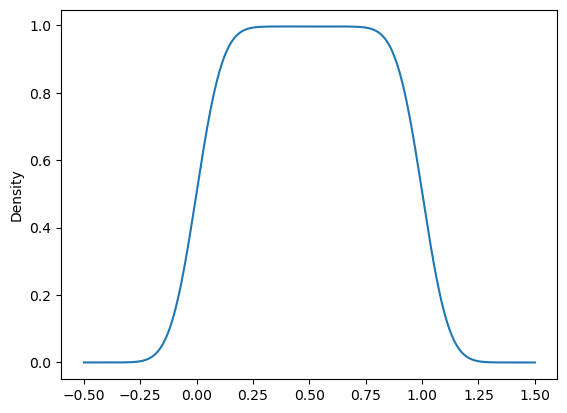

In [13]:
_df['o'].plot(kind='kde')

<Axes: xlabel='o'>

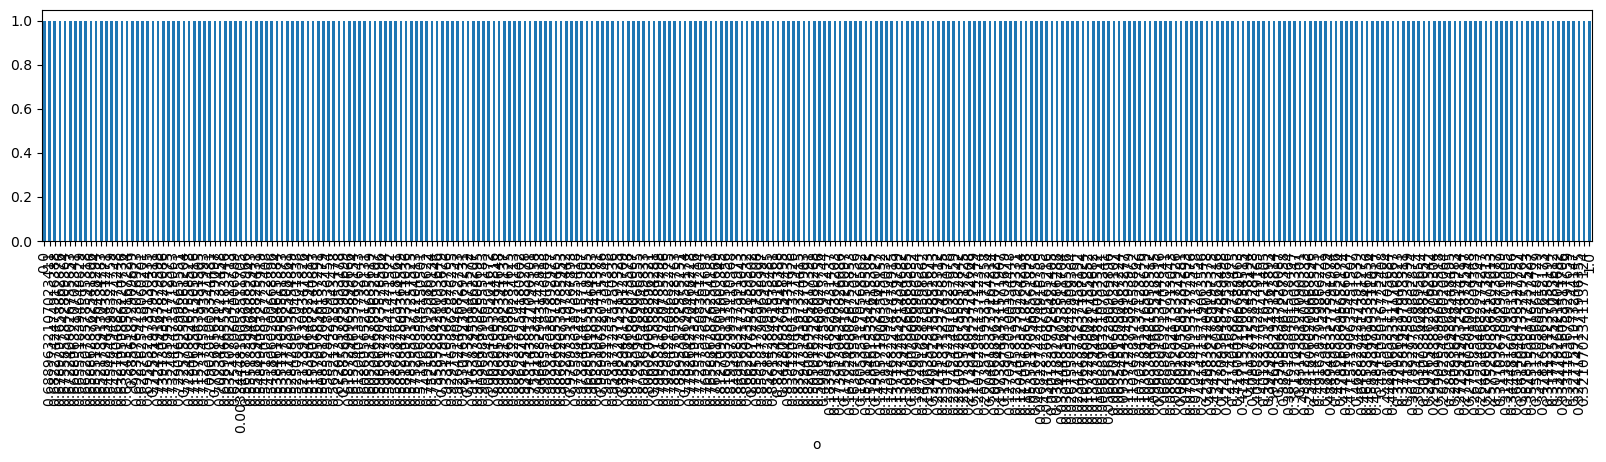

In [14]:
_df['o'].value_counts().plot(kind='bar', figsize=(20, 3))

In [15]:
get_entropy(_df['o'].value_counts())

8.228818690495883

In [16]:
get_entropy(_df['c'].value_counts())

3.321928094887362

<Axes: xlabel='c'>

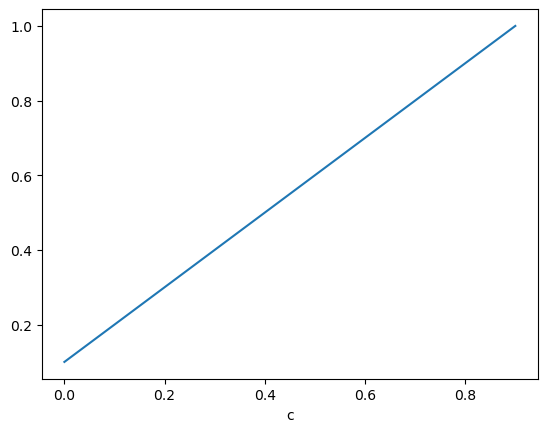

In [17]:
(_df['c'].value_counts().cumsum() / _df.shape[0]).plot(kind='line')

<Axes: ylabel='Density'>

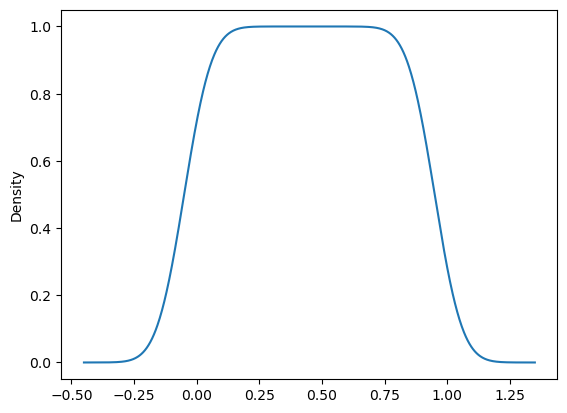

In [18]:
_df['c'].plot(kind='kde')